# Time Series Modelling Case Study: Oil Price Forecasting Using ARIMA: A Time Series Analysis

In [83]:
#Import all necessary libraries

# Core Libraries
import pandas as pd                      # Data manipulation and analysis
import numpy as np                       # Numerical computing
import warnings                          # Suppress warnings for clean output
warnings.filterwarnings("ignore")

# Visualization Libraries
import matplotlib.pyplot as plt          # Basic plotting
import matplotlib.dates as mdates        # Date formatting for x-axis
import seaborn as sns                    # Enhanced statistical plotting

# Time Series Plotting Utilities
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF/PACF plots

# Stationarity Tests
from statsmodels.tsa.stattools import adfuller                 # Augmented Dickey-Fuller Test

# Transformation Utilities
from scipy.stats import boxcox                                  # Box-Cox transformation
from scipy.special import inv_boxcox                            # Inverse Box-Cox transformation

# ARIMA Model
from statsmodels.tsa.arima.model import ARIMA                  # ARIMA modeling

# SARIMA Model
from statsmodels.tsa.statespace.sarimax import SARIMAX         # Seasonal ARIMA

# Exponential Smoothing (ETS) Model
from statsmodels.tsa.holtwinters import ExponentialSmoothing   # ETS modeling

# Prophet Model
from prophet import Prophet                                     # Facebook Prophet model

# Model Evaluation
from sklearn.metrics import mean_squared_error                 # RMSE calculation

# Real-world Data Retrieval (e.g., WTI prices from FRED)
from pandas_datareader.data import DataReader                  # Fetch financial data from web
import datetime                                                # For handling date ranges


# Part 1:ARIMA MODEL

**Data loading and performing EDA**

**1. Data Loading and Initial Exploration**
In this project, we analyze and forecast oil prices using time series techniques. The data used spans from July 1, 2020 to December 30, 2022, and includes daily oil prices in USD. This section focuses on the initial stages: loading the data, cleaning it, and conducting exploratory data analysis (EDA).
ty**.
quality.
lity**.
quality.


In [84]:
# Step 1: Load the CSV
file_path = 'C:/Users/sushm/Downloads/oil_price.csv'  # Replace if needed
data = pd.read_csv(file_path)

# Step 2: Check and drop missing values
print("Missing Values (before cleaning):")
print(data.isnull().sum())

data = data.dropna()

# Step 3: Convert 'Date' to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'], format='%b %d, %Y')
data.set_index('Date', inplace=True)

# Step 4: Check again after cleaning
print("\n Missing Values (after cleaning):")
print(data.isnull().sum())

# Step 5: Quick data overview
display(data.head())
print(data.info())
print(data.describe())

Missing Values (before cleaning):
Date     595
Price    595
dtype: int64

 Missing Values (after cleaning):
Price    0
dtype: int64


,Price
Date,
2020-07-01,42.18
2020-07-02,43.19
2020-07-03,42.92
2020-07-06,42.73
2020-07-07,43.28


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 635 entries, 2020-07-01 to 2022-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   635 non-null    float64
dtypes: float64(1)
memory usage: 9.9 KB
None
            Price
count  635.000000
mean    77.214110
std     23.898162
min     36.330000
25%     61.130000
50%     75.500000
75%     94.275000
max    133.180000


**1.1 Loading the Dataset**
The dataset, oil_price.csv, was loaded using pandas. Initial inspection revealed 595 missing values in both the 'Date' and 'Price' columns. These rows were dropped to ensure data quality.

**1.2 Exploratory Data Analysis (EDA)**

We performed several visual analyses to understand the behavior of oil prices over time.

**1.Time Series Plot**
A line plot of daily prices shows moderate volatility with upward spikes in mid-2022.

**2.Histogram with KDE**
This plot shows the distribution of oil prices with a right-skewed curve, indicating occasional high prices.

**3.Rolling Statistics (30-day)**
A rolling window mean and standard deviation was plotted to assess local trends and volatility.

**4.Autocorrelation and Partial Autocorrelation**
These plots were generated to understand lags and seasonality in the series. Strong autocorrelation at short lags indicated a need for differencing.

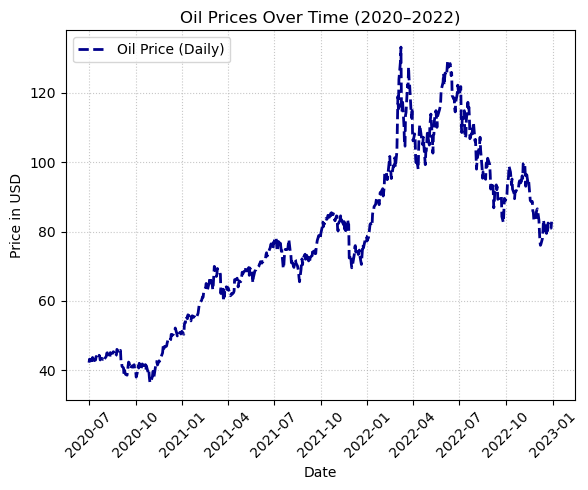

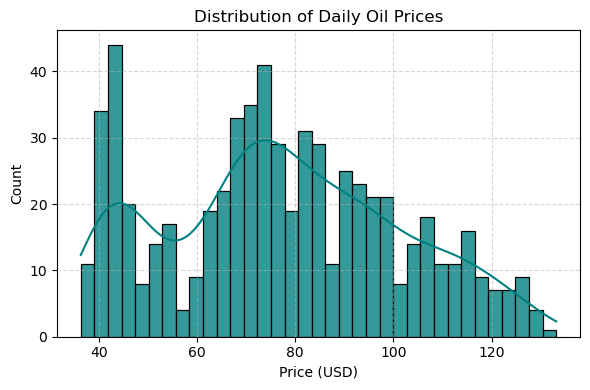

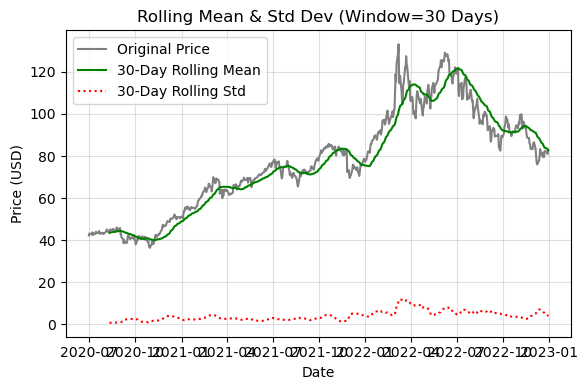

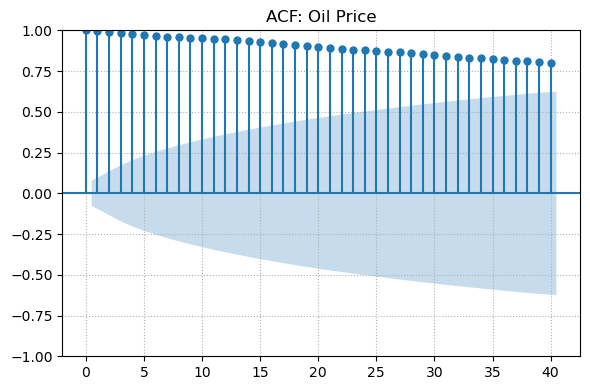

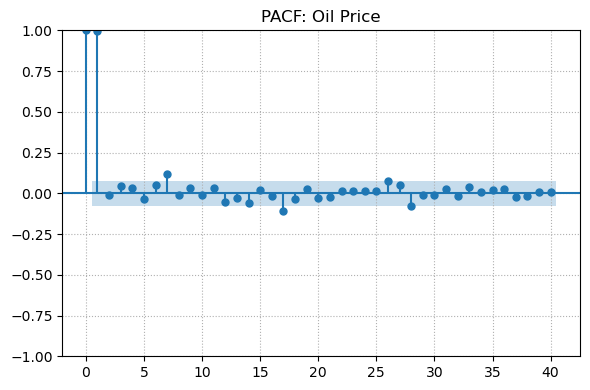

In [85]:
# 1.Time Series Plot 
plt.figure(figsize=(6, 5))
plt.plot(data['Price'], label='Oil Price (Daily)', linewidth=2, linestyle='--', color='darkblue')
plt.title("Oil Prices Over Time (2020–2022)")
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(visible=True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# 2.Histogram + KDE 
plt.figure(figsize=(6, 4))
sns.histplot(data['Price'], bins=35, kde=True, color='teal', edgecolor='black', alpha=0.8)
plt.title("Distribution of Daily Oil Prices")
plt.xlabel("Price (USD)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 3.Rolling Statistics (30-day)
window_size = 30
mean_roll = data['Price'].rolling(window=window_size).mean()
std_roll = data['Price'].rolling(window=window_size).std()

plt.figure(figsize=(6, 4))
plt.plot(data['Price'], label='Original Price', color='gray')
plt.plot(mean_roll, label=f'{window_size}-Day Rolling Mean', color='green', linestyle='-')
plt.plot(std_roll, label=f'{window_size}-Day Rolling Std', color='red', linestyle=':')
plt.title(f"Rolling Mean & Std Dev (Window={window_size} Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

# 4.ACF and PACF plots
plt.figure(figsize=(6, 4))
plot_acf(data['Price'], lags=40, ax=plt.gca())
plt.title("ACF: Oil Price")
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plot_pacf(data['Price'], lags=40, ax=plt.gca())
plt.title("PACF: Oil Price")
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()



**Performing ADF test to check series stationary or not** 

In [86]:
# ADF test function with better output and critical values
def adfuller_test(series, title='ADF Test'):
    print(f"\n {title} Results")
    
    result = adfuller(series)
    labels = [
        "ADF Statistic", 
        "p-value", 
        "# Lags Used", 
        "Number of Observations Used"
    ]
    
    # Print the main values
    for value, label in zip(result[:4], labels):
        print(f"{label:30}: {value:.4f}" if isinstance(value, float) else f"{label:30}: {value}")
    
    # Print critical values
    print("\nCritical Values:")
    for key, val in result[4].items():
        print(f"   {key} : {val:.4f}")
    
    # Conclusion
    if result[1] <= 0.05:
        print("\n Conclusion: Series is Stationary (Reject H₀)")
    else:
        print("\n Conclusion: Series is Non-Stationary (Fail to Reject H₀)")

# Run the test on your series
adfuller_test(data['Price'], title='ADF Test on Oil Prices')




 ADF Test on Oil Prices Results
ADF Statistic                 : -1.5986
p-value                       : 0.4843
# Lags Used                   : 16
Number of Observations Used   : 618

Critical Values:
   1% : -3.4410
   5% : -2.8662
   10% : -2.5693

 Conclusion: Series is Non-Stationary (Fail to Reject H₀)


In [ ]:
**Applying Box-cox Transformation**

In [87]:
# Step 1: Check if data is positive (Box-Cox requires this)
if (data['Price'] <= 0).any():
    raise ValueError("Box-Cox transformation requires all values to be positive.")

# Step 2: Apply Box-Cox transformation
data['Price_box'], lam = boxcox(data['Price'])
print(f"\n Box-Cox Transformation Applied — Optimal Lambda: {lam:.4f}")



 Box-Cox Transformation Applied — Optimal Lambda: 0.6162


C:\Users\sushm\AppData\Local\Temp\ipykernel_37632\975008951.py:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\sushm\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


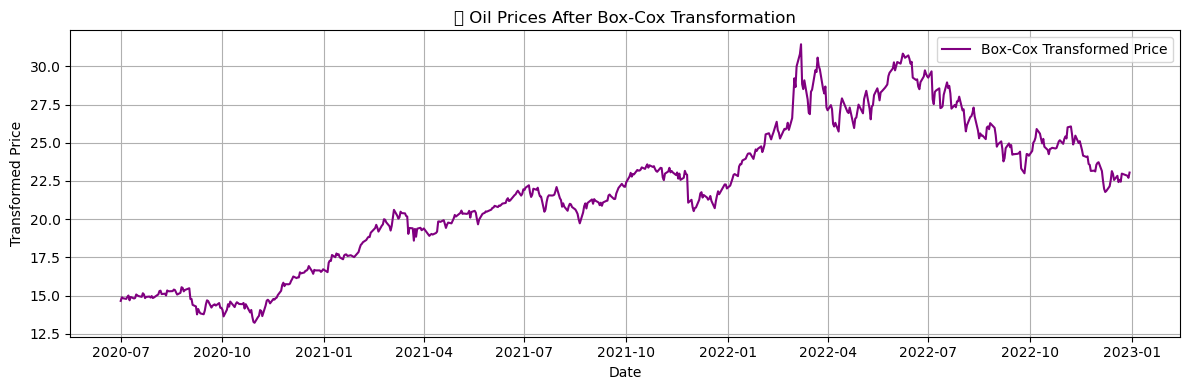

In [9]:
# Line Plot of Box-Cox Transformed Series
plt.figure(figsize=(6, 4))
plt.plot(data.index, data['Price_box'], color='purple', label='Box-Cox Transformed Price')
plt.title("Oil Prices After Box-Cox Transformation")
plt.xlabel("Date")
plt.ylabel("Transformed Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Making the data stationary by applying first-order differencing**

In [88]:
# Use Box-Cox transformed series
series = data['Price_box'].copy()

# ADF Test
adf_result = adfuller(series)
print(f"\nADF Test p-value: {adf_result[1]:.4f}")


# Check if differencing is needed
if adf_result[1] > 0.05:
    series = series.diff().dropna()
    print(" First-order differencing applied — now stationary.")
else:
    print(" Series is already stationary.")

# Save the final stationary series
data['Price_diff'] = series



ADF Test p-value: 0.4790
 First-order differencing applied — now stationary.


**Performing ADF test to confirm series is stationary**

In [91]:
# ADF test function with better output and critical values
def adfuller_test(series, title='ADF Test'):
    print(f"\n {title} Results")
    
    result = adfuller(series)
    labels = [
        "ADF Statistic", 
        "p-value", 
        "# Lags Used", 
        "Number of Observations Used"
    ]
    
    # Print the main values
    for value, label in zip(result[:4], labels):
        print(f"{label:30}: {value:.4f}" if isinstance(value, float) else f"{label:30}: {value}")
    
    # Print critical values
    print("\nCritical Values:")
    for key, val in result[4].items():
        print(f"   {key} : {val:.4f}")
    
    # Conclusion
    if result[1] <= 0.05:
        print("\n Conclusion: Series is Stationary (Reject H₀)")
    else:
        print("\n Conclusion: Series is Non-Stationary (Fail to Reject H₀)")

# Run the test on your series
adfuller_test(series, title='ADF Test on Oil Prices')




 ADF Test on Oil Prices Results
ADF Statistic                 : -5.2400
p-value                       : 0.0000
# Lags Used                   : 15
Number of Observations Used   : 618

Critical Values:
   1% : -3.4410
   5% : -2.8662
   10% : -2.5693

 Conclusion: Series is Stationary (Reject H₀)


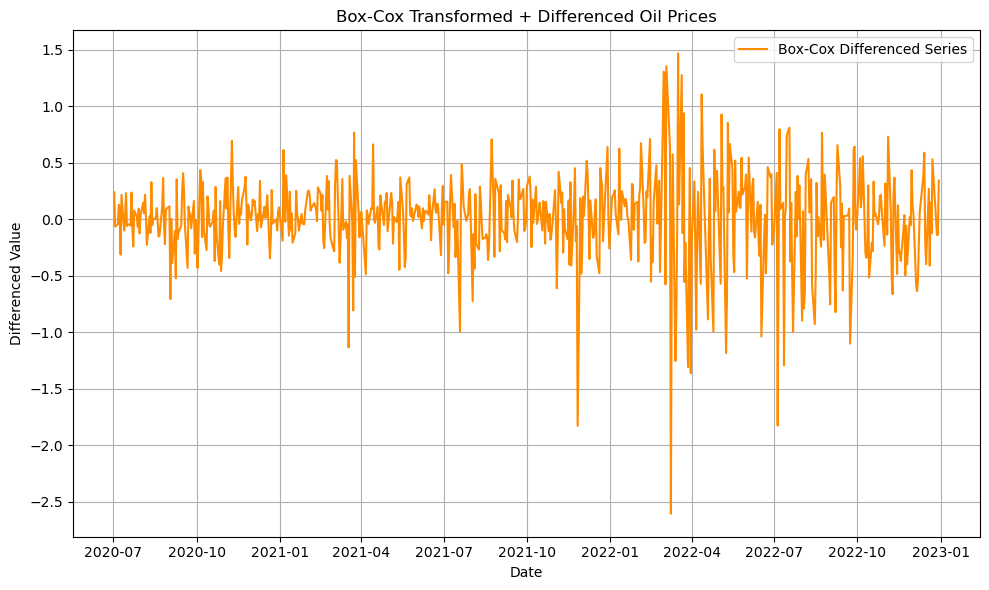

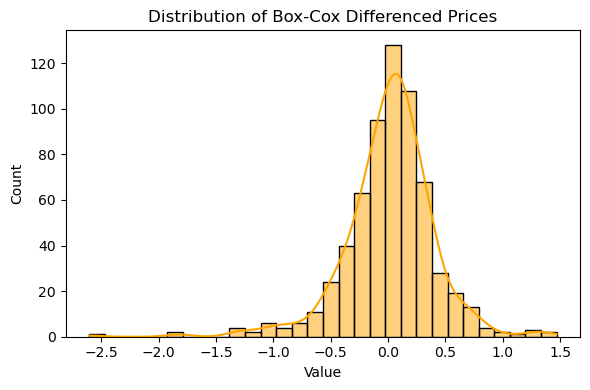

<Figure size 600x400 with 0 Axes>

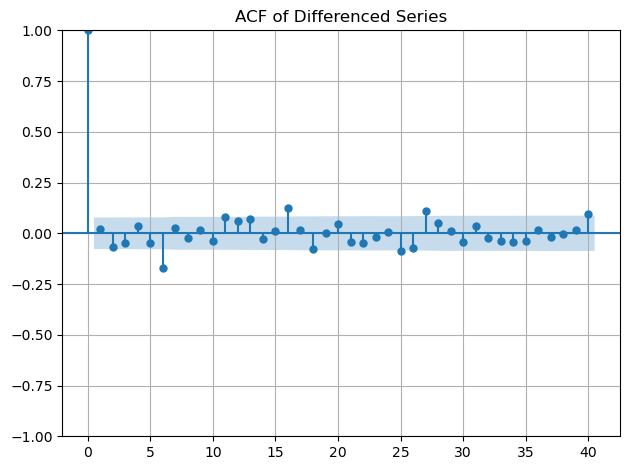

<Figure size 600x400 with 0 Axes>

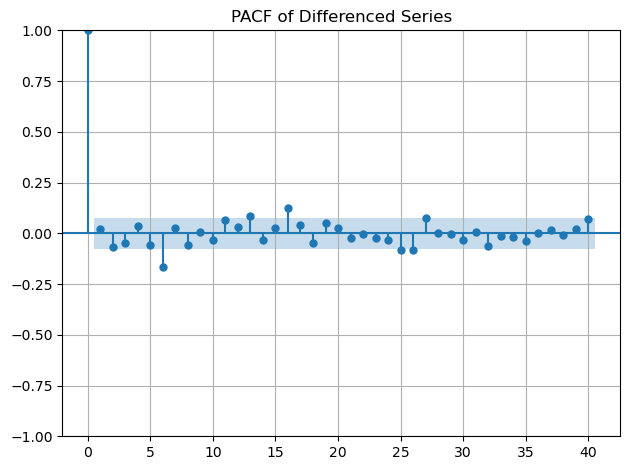

In [92]:

# First-order differencing
data_diff = data['Price_box'].diff().dropna()

# Line Plot: Box-Cox Differenced Series
plt.figure(figsize=(10, 6))
plt.plot(data_diff, color='darkorange', label='Box-Cox Differenced Series')
plt.title("Box-Cox Transformed + Differenced Oil Prices")
plt.xlabel("Date")
plt.ylabel("Differenced Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Histogram + KDE
plt.figure(figsize=(6, 4))
sns.histplot(data_diff, bins=30, kde=True, color='orange', edgecolor='black')
plt.title("Distribution of Box-Cox Differenced Prices")
plt.xlabel("Value")
plt.tight_layout()
plt.show()

# ACF and PACF
plt.figure(figsize=(6, 4))
plot_acf(data_diff, lags=40)
plt.title("ACF of Differenced Series")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plot_pacf(data_diff, lags=40)
plt.title("PACF of Differenced Series")
plt.grid(True)
plt.tight_layout()
plt.show()


**Defining an ARMA model**

                               SARIMAX Results                                
Dep. Variable:              Price_box   No. Observations:                  634
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -299.499
Date:                Mon, 07 Jul 2025   AIC                            610.998
Time:                        14:29:24   BIC                            637.710
Sample:                             0   HQIC                           621.370
                                - 634                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0133      0.016      0.818      0.413      -0.019       0.045
ar.L1         -0.0262      0.030     -0.871      0.384      -0.085       0.033
ar.L2         -0.9511      0.031    -31.053      0.0

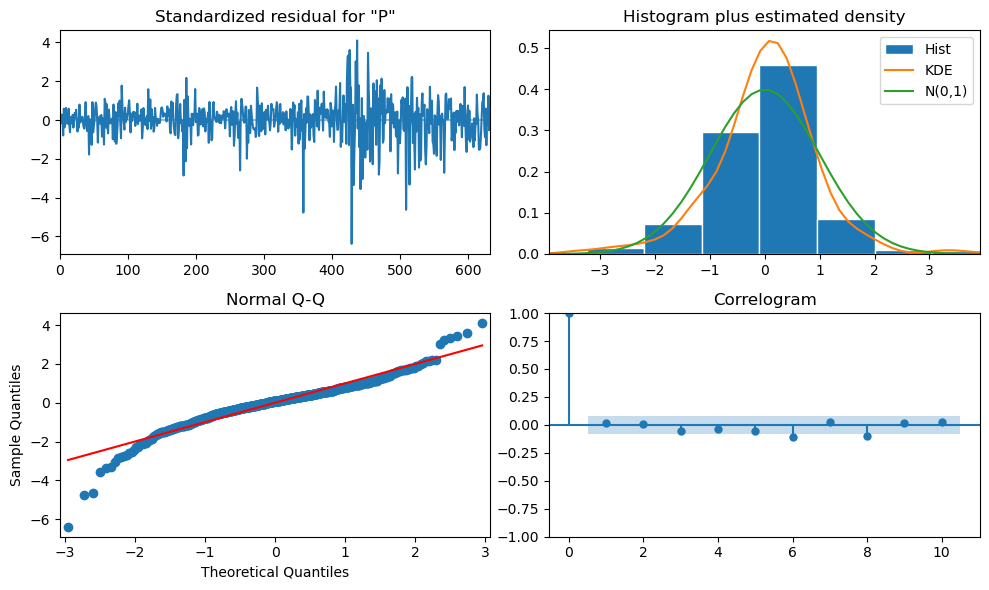

In [93]:

# Already Box-Cox transformed + differenced

# Fit ARMA(2,2) — ARIMA with d=0
model = ARIMA(data_diff, order=(2, 0, 2))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

#  diagnostic plots
model_fit.plot_diagnostics(figsize=(10, 6))
plt.tight_layout()
plt.show()


# ARIMA Model

**Finding the best model parameters: p,d,q using the AIC likelihood method by loop over all possible parameter combinations for p=[0,8], d=[0,2] and q=[0,8]**

In [94]:
# Use Box-Cox transformed price series
series = data['Price_box']

best_aic = float("inf")
best_order = None

print("Starting full ARIMA(p,d,q) Grid Search...\n")

# Loop over p, d, q
for p in range(9):     # p = 0 to 8
    for d in range(3): # d = 0 to 2
        for q in range(9): # q = 0 to 8
            order = (p, d, q)
            try:
                model = ARIMA(series, order=order).fit()
                aic = model.aic
                print(f"Tested ARIMA{order} → AIC: {aic:.2f}")
                if aic < best_aic:
                    best_aic = aic
                    best_order = order
            except:
                continue

print("\nGrid search complete.")
print(f"Best ARIMA order: {best_order} with AIC = {best_aic:.2f}")


Starting full ARIMA(p,d,q) Grid Search...

Tested ARIMA(0, 0, 0) → AIC: 3732.63
Tested ARIMA(0, 0, 1) → AIC: 2913.41
Tested ARIMA(0, 0, 2) → AIC: 2327.31
Tested ARIMA(0, 0, 3) → AIC: 1873.95
Tested ARIMA(0, 0, 4) → AIC: 1664.59
Tested ARIMA(0, 0, 5) → AIC: 1438.80
Tested ARIMA(0, 0, 6) → AIC: 1308.54
Tested ARIMA(0, 0, 7) → AIC: 1202.04
Tested ARIMA(0, 0, 8) → AIC: 1132.09
Tested ARIMA(0, 1, 0) → AIC: 618.94
Tested ARIMA(0, 1, 1) → AIC: 620.56
Tested ARIMA(0, 1, 2) → AIC: 620.20
Tested ARIMA(0, 1, 3) → AIC: 619.38
Tested ARIMA(0, 1, 4) → AIC: 620.98
Tested ARIMA(0, 1, 5) → AIC: 621.67
Tested ARIMA(0, 1, 6) → AIC: 607.54
Tested ARIMA(0, 1, 7) → AIC: 607.87
Tested ARIMA(0, 1, 8) → AIC: 609.73
Tested ARIMA(0, 2, 0) → AIC: 1042.65
Tested ARIMA(0, 2, 1) → AIC: 626.70
Tested ARIMA(0, 2, 2) → AIC: 628.31
Tested ARIMA(0, 2, 3) → AIC: 627.98
Tested ARIMA(0, 2, 4) → AIC: 627.12
Tested ARIMA(0, 2, 5) → AIC: 628.75
Tested ARIMA(0, 2, 6) → AIC: 629.37
Tested ARIMA(0, 2, 7) → AIC: 614.73
Tested ARIM

                               SARIMAX Results                                
Dep. Variable:              Price_box   No. Observations:                  635
Model:                 ARIMA(6, 1, 7)   Log Likelihood                -285.169
Date:                Mon, 07 Jul 2025   AIC                            598.338
Time:                        14:38:23   BIC                            660.667
Sample:                             0   HQIC                           622.541
                                - 635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0900      0.109      0.827      0.408      -0.123       0.303
ar.L2          0.4277      0.113      3.800      0.000       0.207       0.648
ar.L3          0.0101      0.060      0.168      0.8

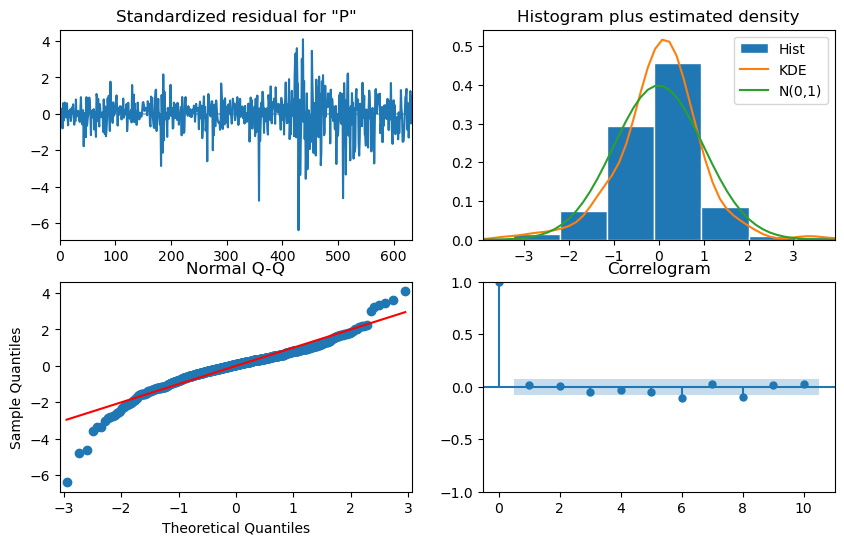

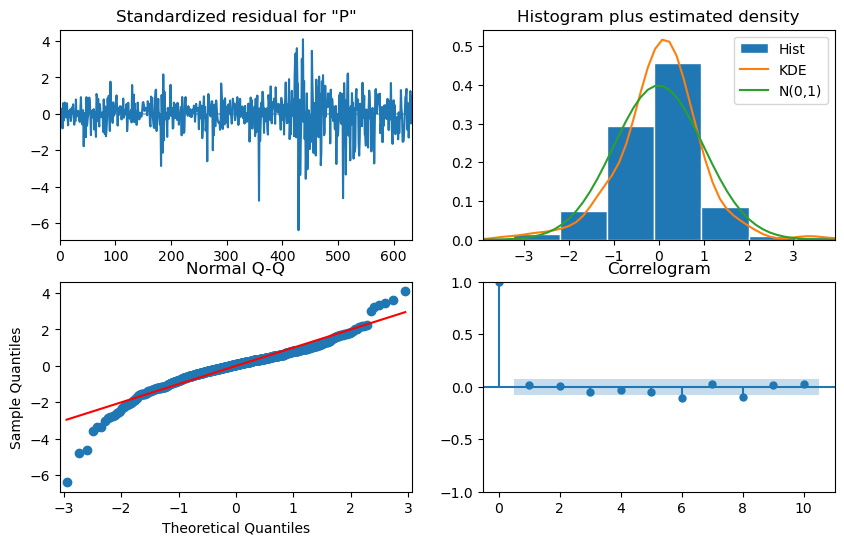

In [95]:
final_model = ARIMA(series, order=best_order).fit()
print(final_model.summary())

#  diagnostic plots
model_fit.plot_diagnostics(figsize=(10, 6))

**Forecast model 24 months into the future**

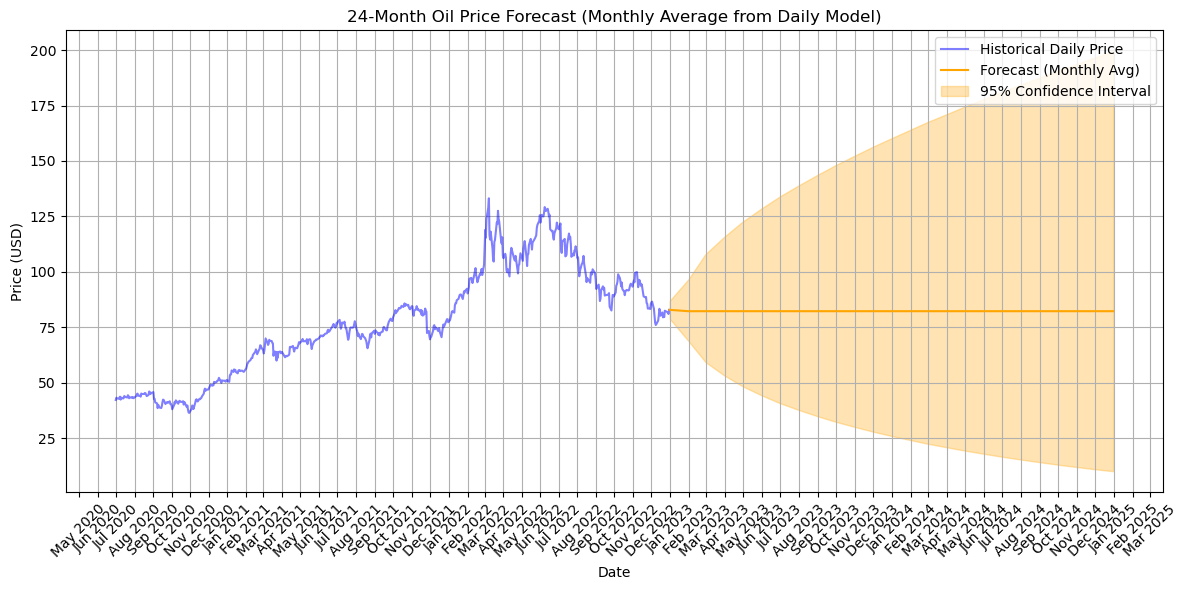

In [96]:
# Step 1: Forecast 730 daily steps (≈ 24 months)
forecast_result = final_model.get_forecast(steps=730)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Step 2: Invert Box-Cox transformation
forecast_usd = inv_boxcox(forecast_mean, lam)

conf_int_usd = pd.DataFrame({
    'lower': inv_boxcox(conf_int.iloc[:, 0], lam),
    'upper': inv_boxcox(conf_int.iloc[:, 1], lam)
}, index=forecast_mean.index)

# Step 3: Create daily datetime index for forecast
last_date = data.index[-1]
forecast_usd.index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=730, freq='D')
conf_int_usd.index = forecast_usd.index

# Step 4: Resample to monthly average forecast
monthly_forecast = forecast_usd.resample('M').mean()
monthly_ci_lower = conf_int_usd['lower'].resample('M').mean()
monthly_ci_upper = conf_int_usd['upper'].resample('M').mean()

# Step 5: Plot historical + forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Price'], label='Historical Daily Price', color='blue', alpha=0.5)
plt.plot(monthly_forecast.index, monthly_forecast, label='Forecast (Monthly Avg)', color='orange')
plt.fill_between(monthly_forecast.index, monthly_ci_lower, monthly_ci_upper,
                 color='orange', alpha=0.3, label='95% Confidence Interval')

plt.title("24-Month Oil Price Forecast (Monthly Average from Daily Model)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
Resample daily prices to monthly average and not performing box-cox transform to get better forcast

ADF Test – Monthly Average Data
ADF Statistic   : -0.6020
p-value         : 0.8705
Critical Values :
   1% : -3.8092
   5% : -3.0216
   10% : -2.6507

ADF Test – Differenced Monthly Data
ADF Statistic   : -3.1882
p-value         : 0.0207
Critical Values :
   1% : -3.8092
   5% : -3.0216
   10% : -2.6507

Starting ARIMA(p,1,q) grid search...

Tested ARIMA(0,1,0) → AIC: 204.94
Tested ARIMA(0,1,1) → AIC: 206.38
Tested ARIMA(0,1,2) → AIC: 208.26
Tested ARIMA(0,1,3) → AIC: 209.21
Tested ARIMA(0,1,4) → AIC: 210.15
Tested ARIMA(0,1,5) → AIC: 208.56
Tested ARIMA(0,1,6) → AIC: 205.53
Tested ARIMA(0,1,7) → AIC: 207.42
Tested ARIMA(0,1,8) → AIC: 207.88
Tested ARIMA(1,1,0) → AIC: 206.48
Tested ARIMA(1,1,1) → AIC: 208.26
Tested ARIMA(1,1,2) → AIC: 210.25
Tested ARIMA(1,1,3) → AIC: 210.91
Tested ARIMA(1,1,4) → AIC: 211.67
Tested ARIMA(1,1,5) → AIC: 211.54
Tested ARIMA(1,1,6) → AIC: 207.49
Tested ARIMA(1,1,7) → AIC: 209.52
Tested ARIMA(1,1,8) → AIC: 209.80
Tested ARIMA(2,1,0) → AIC: 208.28
Tested ARI

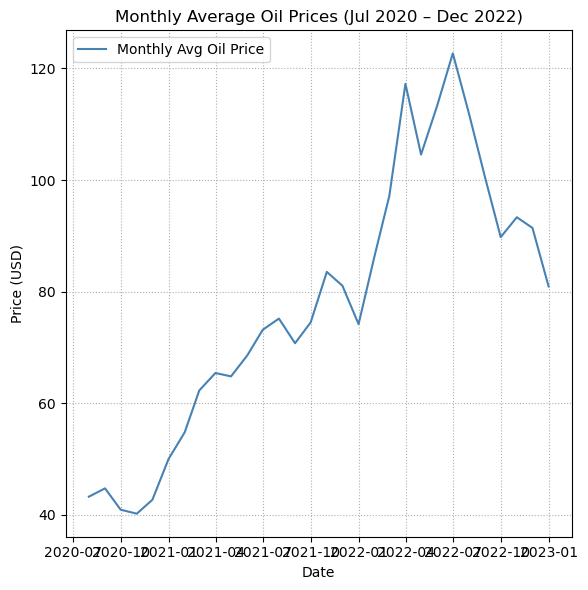

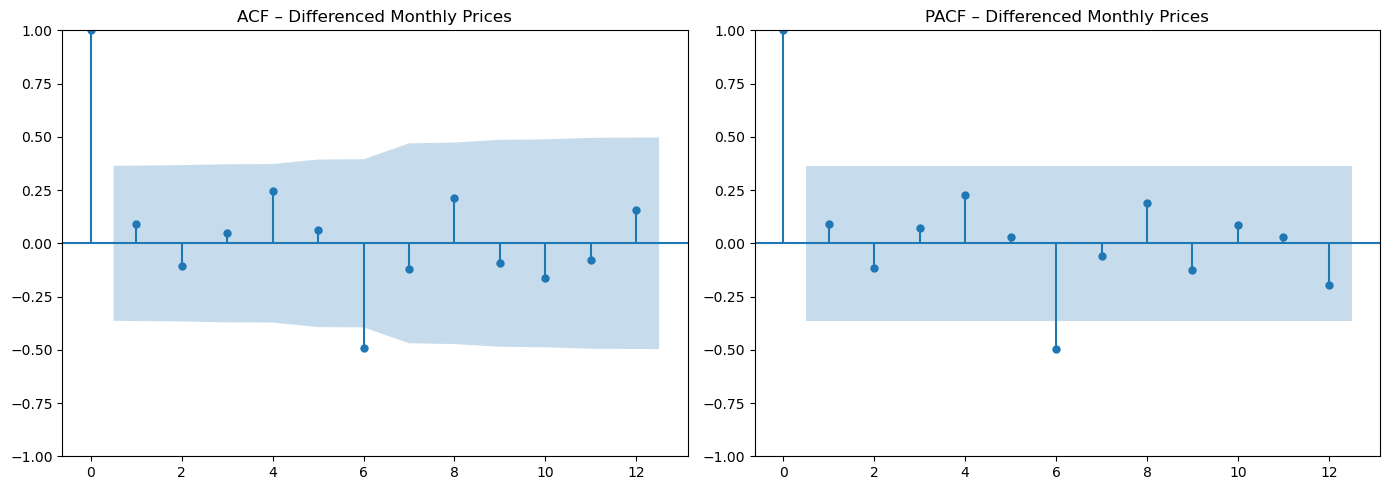

In [97]:
# ------------------------------------------
# Step 1: Resample daily prices to monthly average
# ------------------------------------------
monthly_data = data['Price'].resample('M').mean()

# ------------------------------------------
#  Step 2: ADF test on original monthly data
# ------------------------------------------
adf_result = adfuller(monthly_data.dropna())
print("ADF Test – Monthly Average Data")
print(f"ADF Statistic   : {adf_result[0]:.4f}")
print(f"p-value         : {adf_result[1]:.4f}")
print("Critical Values :")
for key, val in adf_result[4].items():
    print(f"   {key} : {val:.4f}")
print("")

# ------------------------------------------
# Step 3: First-order differencing
# ------------------------------------------
monthly_diff = monthly_data.diff().dropna()

# ADF test after differencing
adf_diff_result = adfuller(monthly_diff)
print("ADF Test – Differenced Monthly Data")
print(f"ADF Statistic   : {adf_diff_result[0]:.4f}")
print(f"p-value         : {adf_diff_result[1]:.4f}")
print("Critical Values :")
for key, val in adf_diff_result[4].items():
    print(f"   {key} : {val:.4f}")
print("")

# ------------------------------------------
# Step 4: Grid search for best ARIMA(p,1,q)
# ------------------------------------------
best_aic = float("inf")
best_order = None

print("Starting ARIMA(p,1,q) grid search...\n")
for p in range(9):
    for q in range(9):
        try:
            model = ARIMA(monthly_data, order=(p, 1, q))
            result = model.fit()
            aic = result.aic
            print(f"Tested ARIMA({p},1,{q}) → AIC: {aic:.2f}")
            if aic < best_aic:
                best_aic = aic
                best_order = (p, 1, q)
        except:
            continue

print(f"\n Best ARIMA Order: {best_order} with AIC = {best_aic:.2f}")

# ------------------------------------------
# Step 5: Plot monthly average oil prices
# ------------------------------------------
plt.figure(figsize=(6, 6))
plt.plot(monthly_data, label='Monthly Avg Oil Price', color='steelblue')
plt.title('Monthly Average Oil Prices (Jul 2020 – Dec 2022)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------
# Step 6: ACF and PACF plots
# ------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(monthly_diff, ax=axes[0], lags=12)
axes[0].set_title("ACF – Differenced Monthly Prices")

plot_pacf(monthly_diff, ax=axes[1], lags=12, method='ywm')
axes[1].set_title("PACF – Differenced Monthly Prices")

plt.tight_layout()
plt.show()


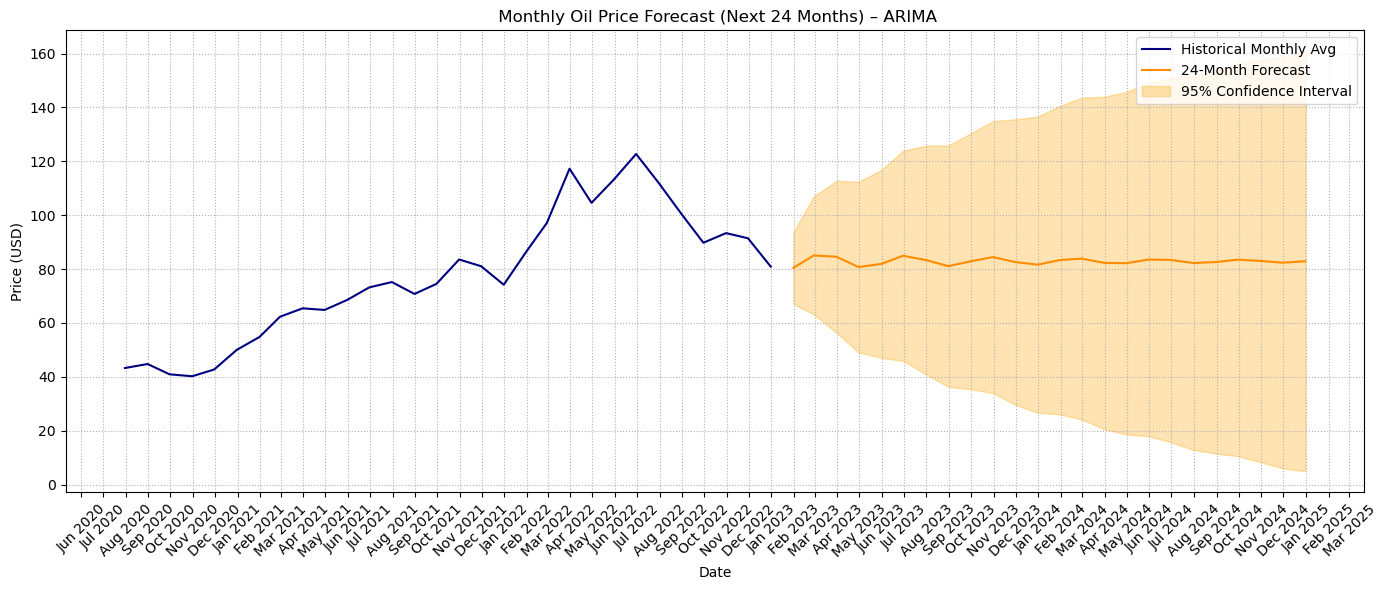

 In-sample RMSE: 10.44 USD


In [99]:

# ----------------------------------------
# Resample to monthly average prices
# ----------------------------------------
monthly_data = data['Price'].resample('M').mean()

# ----------------------------------------
# Fit ARIMA model using best order
# (This could be (2,1,2) or from your grid search)
# ----------------------------------------
best_order = (2, 1, 2)
model_final = ARIMA(monthly_data, order=best_order)
fitted_model = model_final.fit()

# ----------------------------------------
# Forecast next 24 months
# ----------------------------------------
forecast_steps = 24
forecast_result = fitted_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Create future monthly index
forecast_index = pd.date_range(
    start=monthly_data.index[-1] + pd.offsets.MonthEnd(1),
    periods=forecast_steps,
    freq='M'
)

# Reindex forecast and confidence intervals
forecast_mean.index = forecast_index
conf_int.index = forecast_index

# ----------------------------------------
# Plot forecast with confidence interval
# ----------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(monthly_data, label='Historical Monthly Avg', color='navy')
plt.plot(forecast_mean, label='24-Month Forecast', color='darkorange')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='orange', alpha=0.3, label='95% Confidence Interval')

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.title(" Monthly Oil Price Forecast (Next 24 Months) – ARIMA")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------
# In-sample RMSE
# ----------------------------------------
fitted_vals = fitted_model.fittedvalues
aligned_actual = monthly_data.loc[fitted_vals.index]
rmse = np.sqrt(mean_squared_error(aligned_actual, fitted_vals))
print(f" In-sample RMSE: {rmse:.2f} USD")


**Retrieve the oil price data to the current date and plot with your forecast as a comparison.**

**Oil Price Forecast vs. Actual Data Comparison**

To evaluate the accuracy and relevance of our ARIMA model's forecast, we retrieve the most recent West Texas Intermediate (WTI) crude oil price data from the Federal Reserve Economic Data (FRED) database. This allows for a direct comparison between our projected future prices and the actual market movements since the end of our historical training data.

The following code block fetches daily WTI prices, resamples them to monthly averages to align with our forecast frequency, and then plots them alongside the historical data, the 24-month forecast, and its confidence interval. This visualization provides a clear picture of how well our model's predictions align with real-world oil price trends.

In [100]:
start = datetime.datetime(2022, 1, 1)
end = datetime.datetime.today()

# Read WTI Crude oil price data from FRED
real_wti = DataReader("MCOILWTICO", "fred", start, end)
real_wti.rename(columns={'MCOILWTICO': 'Actual_Price'}, inplace=True)

# Resample to monthly average
real_wti = real_wti.resample('M').mean()


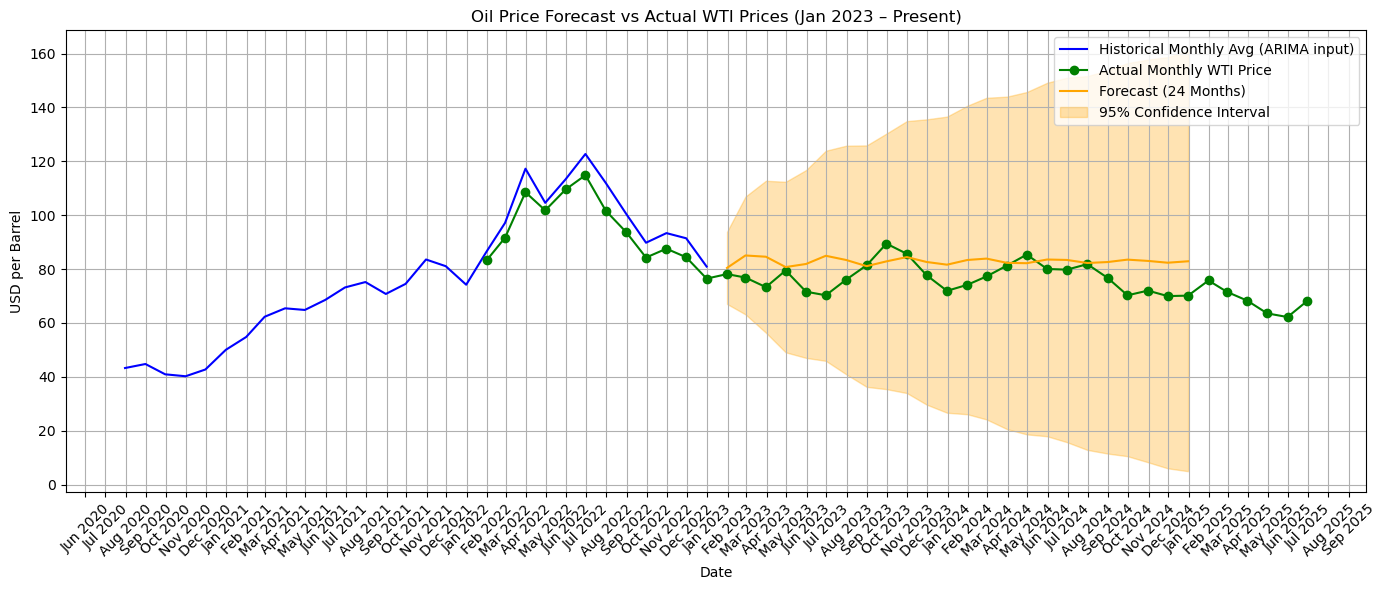

In [101]:
plt.figure(figsize=(14, 6))

# 1. Model input data (historic)
plt.plot(df_monthly, label='Historical Monthly Avg (ARIMA input)', color='blue')

# 2. Actual WTI price (real data)
plt.plot(real_wti.index, real_wti['Actual_Price'], label='Actual Monthly WTI Price', color='green', marker='o')

# 3. Forecasted future values
plt.plot(forecast_index, forecast_mean_array, label='Forecast (24 Months)', color='orange')

# 4. Confidence interval
plt.fill_between(forecast_index, lower_array, upper_array,
                 color='orange', alpha=0.3, label='95% Confidence Interval')

# Format plot
plt.title('Oil Price Forecast vs Actual WTI Prices (Jan 2023 – Present)')
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Forecast Evaluation: Root Mean Squared Error (RMSE)**
To quantitatively assess the performance of our ARIMA forecast against the actual WTI oil prices, we calculate the Root Mean Squared Error (RMSE). RMSE provides a measure of the average magnitude of the errors, indicating how concentrated the data is around the line of best fit. A lower RMSE value suggests a better fit of the model to the observed data.

In [103]:
# Align actual vs forecast
actual = real_wti.loc[forecast_index]['Actual_Price']
predicted = forecast_mean_array[:len(actual)]

# Compute RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"RMSE between forecast and actual WTI: {rmse:.2f} USD")



RMSE between forecast and actual WTI: 8.04 USD


# PART 2

**Build the required model**

# 1.SARIMA (Seasonal ARIMA) MODEL

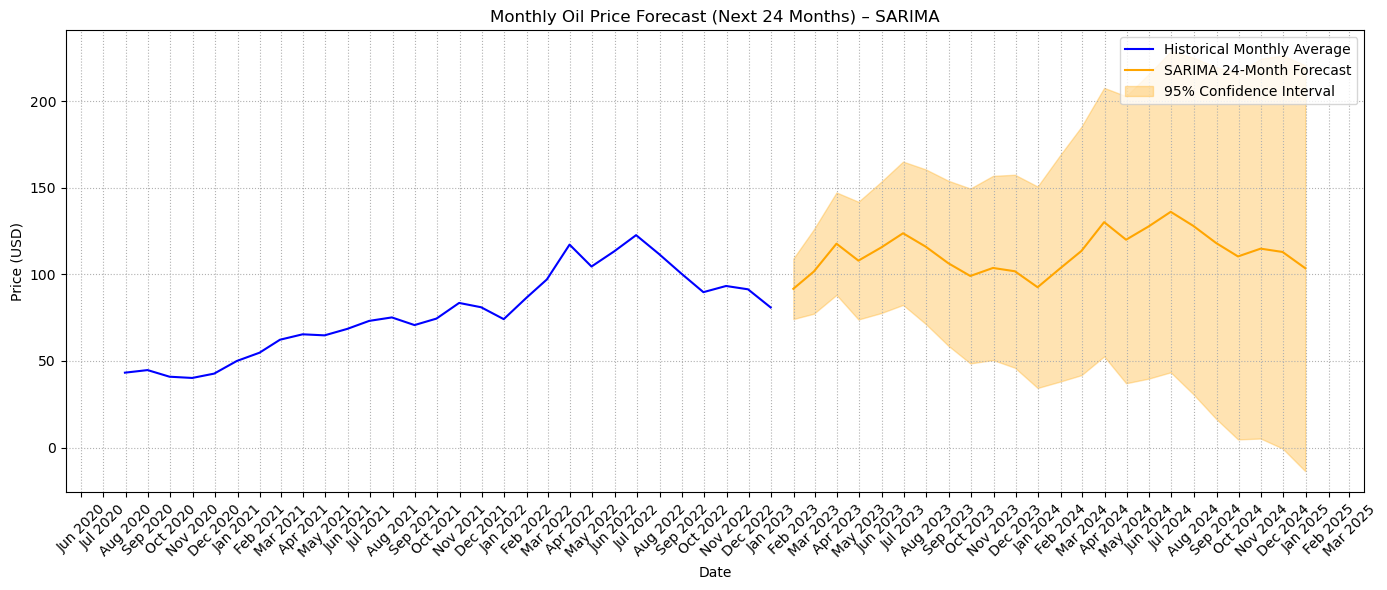

In-sample RMSE (SARIMA): 11.36 USD


In [104]:

# Load and preprocess data
data = pd.read_csv('C:/Users/sushm/Downloads/oil_price.csv')  # Adjust the path if needed
data.dropna(inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%b %d, %Y')
data.set_index('Date', inplace=True)

# Resample to monthly average
monthly_data = data['Price'].resample('M').mean()

# Fit SARIMA model
sarima_model = SARIMAX(monthly_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Forecast 24 months
forecast_steps = 24
sarima_forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_mean = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

# Forecast date index
forecast_index = pd.date_range(start=monthly_data.index[-1] + pd.offsets.MonthEnd(1),
                               periods=forecast_steps, freq='M')
forecast_mean.index = forecast_index
conf_int.index = forecast_index

# Plot forecast
plt.figure(figsize=(14, 6))
plt.plot(monthly_data, label='Historical Monthly Average', color='blue')
plt.plot(forecast_index, forecast_mean.values, label='SARIMA 24-Month Forecast', color='orange')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='orange', alpha=0.3, label='95% Confidence Interval')
plt.title("Monthly Oil Price Forecast (Next 24 Months) – SARIMA")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, linestyle=':')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# In-sample RMSE
fitted_vals = sarima_result.fittedvalues
aligned_actual = monthly_data.loc[fitted_vals.index]
rmse_sarima = np.sqrt(mean_squared_error(aligned_actual, fitted_vals))
print(f"In-sample RMSE (SARIMA): {rmse_sarima:.2f} USD")


forecast vs actual oil prices (WTI)

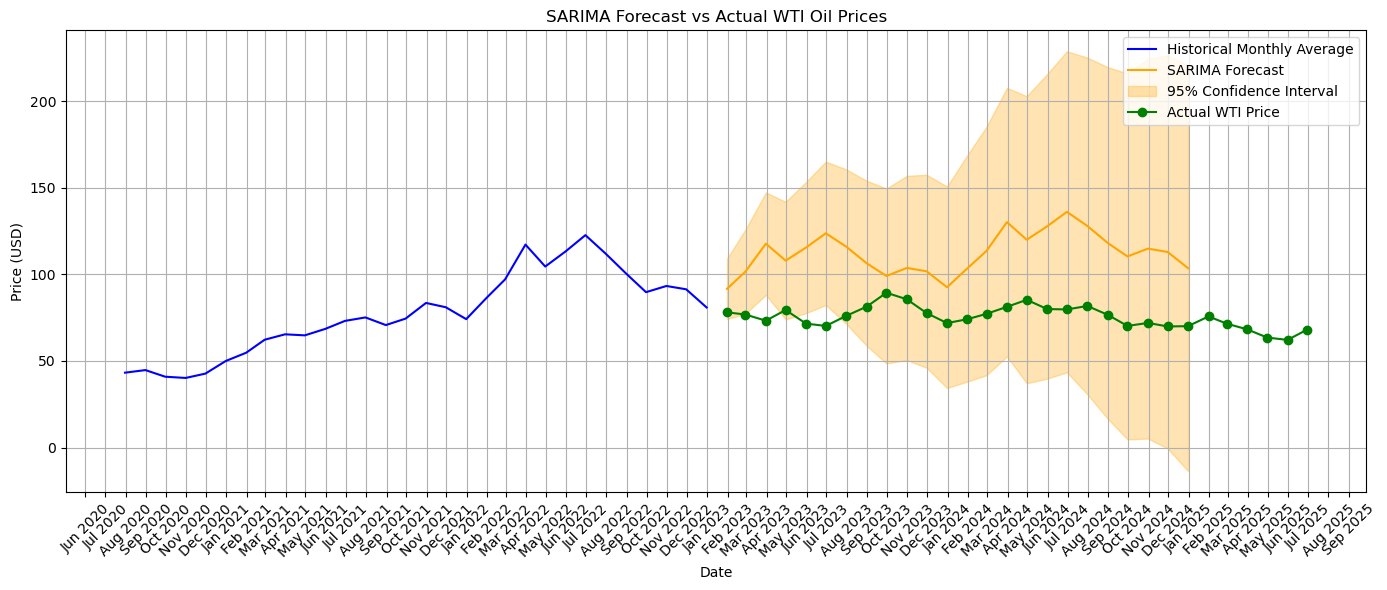

 RMSE between SARIMA forecast and actual WTI: 37.42 USD


In [105]:
# Step 1: Load actual WTI oil prices from FRED
start = monthly_data.index[-1]  # From end of training data
end = datetime.datetime.today()

real_wti = DataReader("MCOILWTICO", "fred", start, end)
real_wti.rename(columns={"MCOILWTICO": "Actual_Price"}, inplace=True)
real_wti = real_wti.resample("M").mean()

# Step 2: Align with SARIMA forecast
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower_CI': conf_int.iloc[:, 0],
    'Upper_CI': conf_int.iloc[:, 1]
})

# Step 3: Plot forecast vs actual
plt.figure(figsize=(14, 6))
plt.plot(monthly_data, label='Historical Monthly Average', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='SARIMA Forecast', color='orange')
plt.fill_between(forecast_df.index, forecast_df['Lower_CI'], forecast_df['Upper_CI'],
                 color='orange', alpha=0.3, label='95% Confidence Interval')
plt.plot(real_wti.index, real_wti['Actual_Price'], label='Actual WTI Price', color='green', marker='o')

plt.title("SARIMA Forecast vs Actual WTI Oil Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 4: Compute RMSE on overlapping forecast range
# Only where actual and forecast overlap
common_index = real_wti.index.intersection(forecast_df.index)
actual_vals = real_wti.loc[common_index, 'Actual_Price']
forecast_vals = forecast_df.loc[common_index, 'Forecast']

rmse_sarima_real = np.sqrt(mean_squared_error(actual_vals, forecast_vals))
print(f" RMSE between SARIMA forecast and actual WTI: {rmse_sarima_real:.2f} USD")


# 2.Exponential Smoothing (ETS) Modelling and Forecasting

RMSE between ETS forecast and actual WTI: 43.11 USD


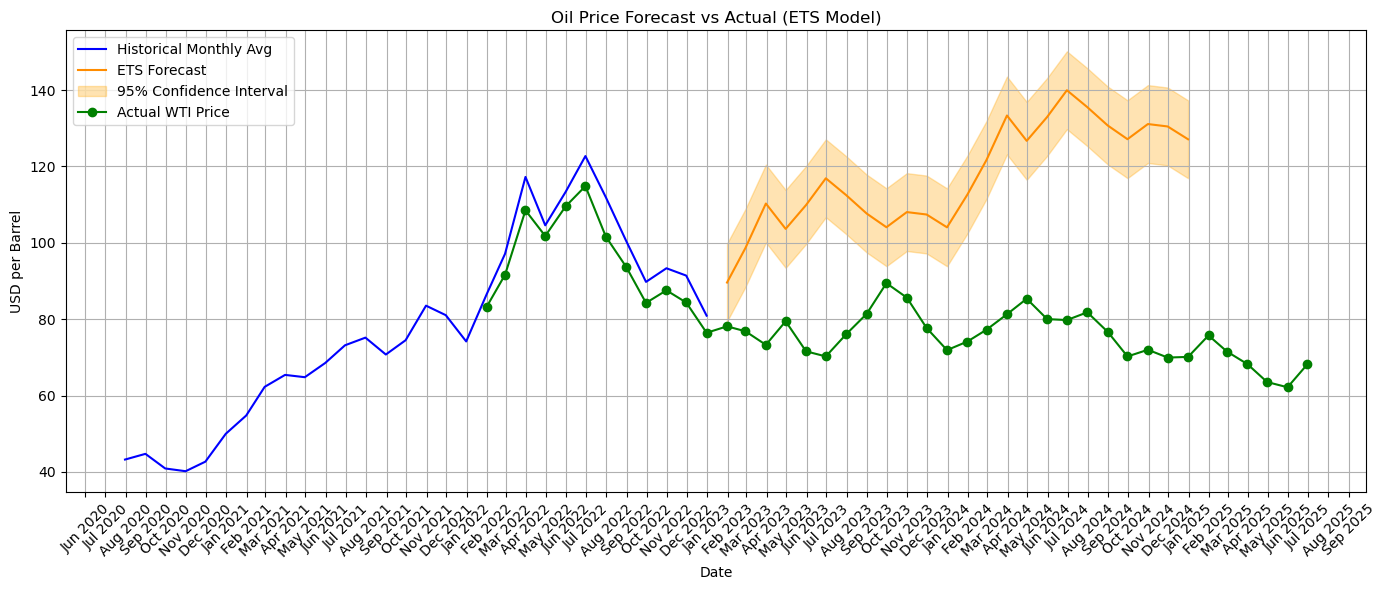

In [106]:
# Load and clean data
data = pd.read_csv('C:/Users/sushm/Downloads/oil_price.csv')
data.dropna(inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%b %d, %Y')
data.set_index('Date', inplace=True)

# Monthly resample
monthly_data = data['Price'].resample('M').mean()

# Fit ETS model
ets_model = ExponentialSmoothing(monthly_data, trend='add', seasonal='add', seasonal_periods=12)
ets_fit = ets_model.fit()

# Forecast 24 months
forecast_steps = 24
ets_forecast = ets_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=monthly_data.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='M')
ets_forecast.index = forecast_index

# Confidence intervals
residuals = monthly_data - ets_fit.fittedvalues
resid_std = residuals.std()
conf_int_upper = ets_forecast + 1.96 * resid_std
conf_int_lower = ets_forecast - 1.96 * resid_std

# Retrieve actual WTI data
start = datetime.datetime(2022, 1, 1)
end = datetime.datetime.today()
real_wti = DataReader("MCOILWTICO", "fred", start, end)
real_wti.rename(columns={'MCOILWTICO': 'Actual_Price'}, inplace=True)
real_wti = real_wti.resample('M').mean()

# Evaluate forecast
actual = real_wti.loc[forecast_index]['Actual_Price']
predicted = ets_forecast[:len(actual)]
rmse_ets = np.sqrt(mean_squared_error(actual, predicted))
print(f"RMSE between ETS forecast and actual WTI: {rmse_ets:.2f} USD")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(monthly_data, label='Historical Monthly Avg', color='blue')
plt.plot(ets_forecast, label='ETS Forecast', color='darkorange')
plt.fill_between(forecast_index, conf_int_lower, conf_int_upper, color='orange', alpha=0.3, label='95% Confidence Interval')
plt.plot(real_wti['Actual_Price'], label='Actual WTI Price', color='green', marker='o')
plt.title("Oil Price Forecast vs Actual (ETS Model)")
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.tight_layout()
plt.show()


# 3.Prophet Model Forecasting

14:40:45 - cmdstanpy - INFO - Chain [1] start processing
14:40:45 - cmdstanpy - INFO - Chain [1] done processing


 In-sample RMSE (Prophet): 6.43 USD


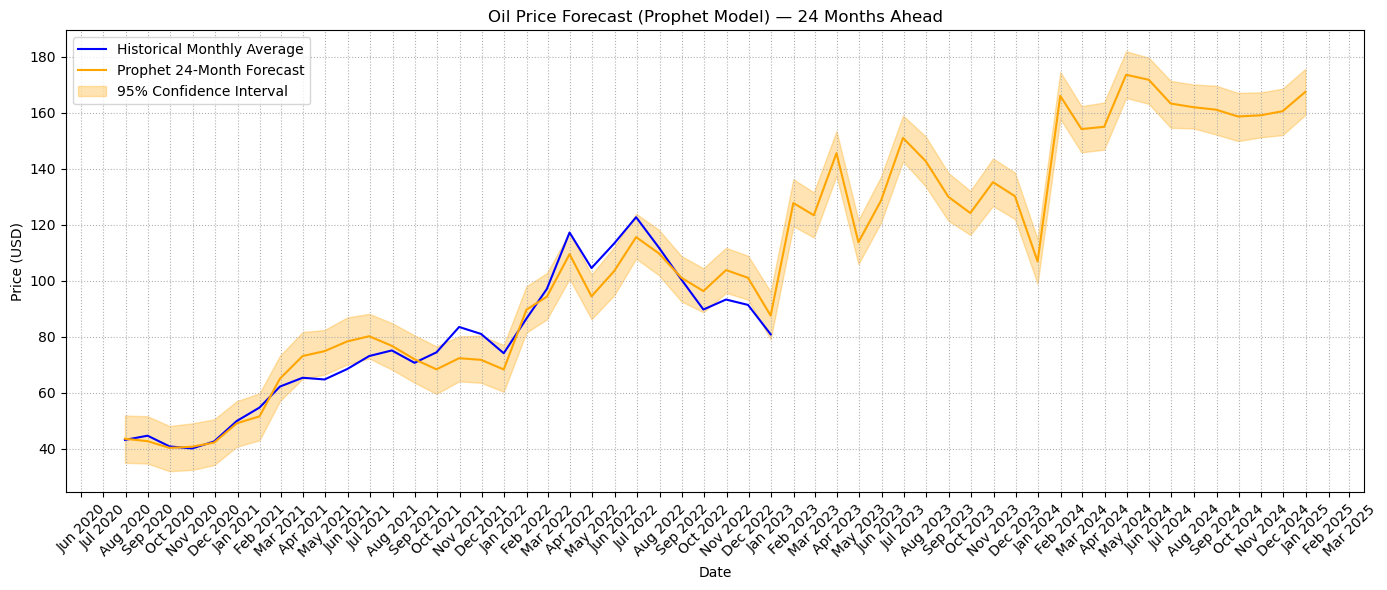

 RMSE between Prophet forecast and actual WTI: 72.13 USD


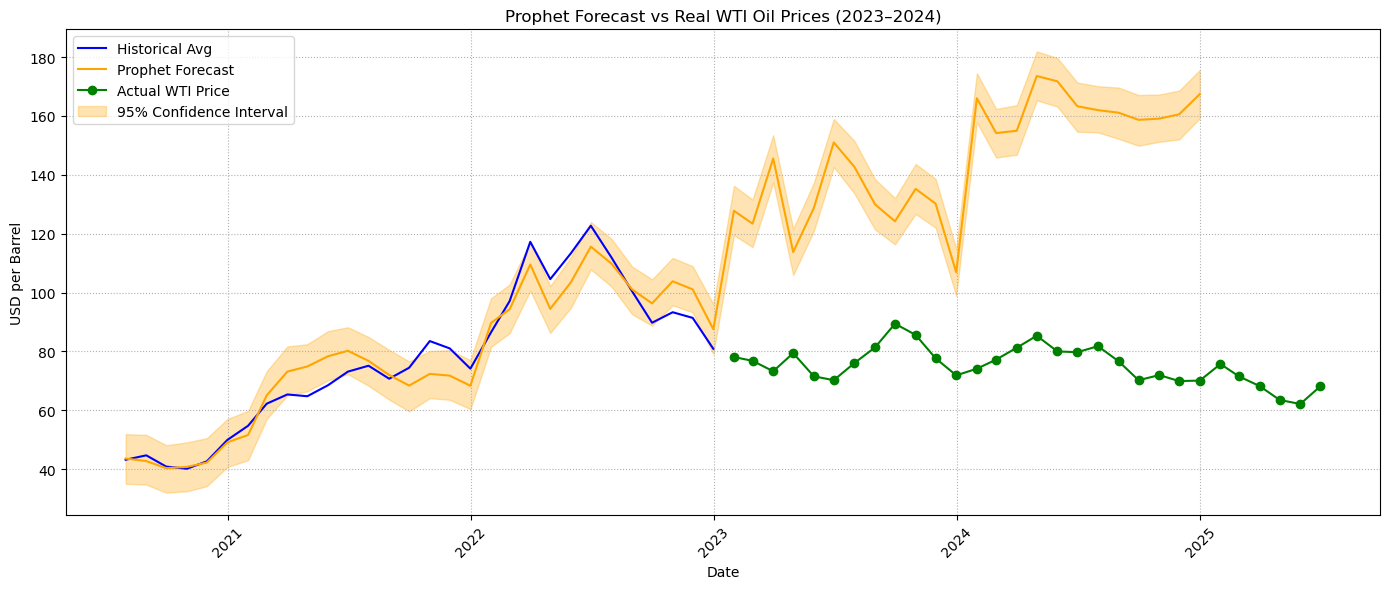

In [107]:

# ---------------------------------------
# Step 1: Load and preprocess the oil price data
# ---------------------------------------
data = pd.read_csv('C:/Users/sushm/Downloads/oil_price.csv')
data.dropna(inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%b %d, %Y')
data.set_index('Date', inplace=True)

# Resample to monthly average
monthly_data = data['Price'].resample('M').mean()

# Prepare data for Prophet
df_prophet = monthly_data.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})

# ---------------------------------------
# Step 2: Build and fit Prophet model
# ---------------------------------------
model = Prophet()
model.fit(df_prophet)

# ---------------------------------------
# Step 3: Make 24-month future forecast
# ---------------------------------------
future = model.make_future_dataframe(periods=24, freq='M')
forecast = model.predict(future)

# ---------------------------------------
# Step 4: In-sample RMSE
# ---------------------------------------
df_forecast = forecast.set_index('ds')[['yhat']]
aligned = pd.concat([monthly_data, df_forecast], axis=1)
aligned.columns = ['actual', 'forecast']
aligned = aligned.dropna()
rmse_prophet = np.sqrt(mean_squared_error(aligned['actual'], aligned['forecast']))
print(f" In-sample RMSE (Prophet): {rmse_prophet:.2f} USD")

# ---------------------------------------
# Step 5: Plot forecast
# ---------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(monthly_data, label='Historical Monthly Average', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet 24-Month Forecast', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='orange', alpha=0.3, label='95% Confidence Interval')

plt.title("Oil Price Forecast (Prophet Model) — 24 Months Ahead")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, linestyle=':')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------------------------------------
# Step 6: Compare with real WTI prices
# ---------------------------------------
start = datetime.datetime(2023, 1, 1)
end = datetime.datetime.today()
real_wti = DataReader("MCOILWTICO", "fred", start, end)
real_wti.rename(columns={"MCOILWTICO": "Actual_Price"}, inplace=True)
real_wti = real_wti.resample('M').mean()

# Align indexes safely
forecast_subset = forecast.set_index('ds')[['yhat']].copy()
forecast_subset = forecast_subset.loc[forecast_subset.index.intersection(real_wti.index)]

actual_vs_forecast = pd.concat([real_wti, forecast_subset], axis=1).dropna()
actual_vs_forecast.columns = ['Actual_Price', 'Forecasted_Price']
rmse_real_vs_forecast = np.sqrt(mean_squared_error(actual_vs_forecast['Actual_Price'],
                                                   actual_vs_forecast['Forecasted_Price']))
print(f" RMSE between Prophet forecast and actual WTI: {rmse_real_vs_forecast:.2f} USD")

# ---------------------------------------
# Final comparison plot
# ---------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(monthly_data, label='Historical Avg', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', color='orange')
plt.plot(real_wti.index, real_wti['Actual_Price'], label='Actual WTI Price', color='green', marker='o')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='orange', alpha=0.3, label='95% Confidence Interval')

plt.title("Prophet Forecast vs Real WTI Oil Prices (2023–2024)")
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
